In [163]:
library('mapdata')
library('tidygeocoder')
library('tidyverse')
library('patchwork')

nhl = read.csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2024/2024-01-09/nhl_player_births.csv')
nhl |> head()

,player_id,first_name,last_name,birth_date,birth_city,birth_country,birth_state_province,birth_year,birth_month
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,8467867,Bryan,Adams,1977-03-20,Fort St. James,CAN,British Columbia,1977,3
2,8445176,Donald,Audette,1969-09-23,Laval,CAN,Quebec,1969,9
3,8460014,Eric,Bertrand,1975-04-16,St-Ephrem,CAN,Quebec,1975,4
4,8460510,Jason,Botterill,1976-05-19,Edmonton,CAN,Alberta,1976,5
5,8459596,Andrew,Brunette,1973-08-24,Sudbury,CAN,Ontario,1973,8
6,8445733,Kelly,Buchberger,1966-12-02,Langenburg,CAN,Saskatchewan,1966,12


I read in Outliers, written by Malcolm Gladwell, that sports players in the North American system are disproportionately born earlier in the year based on how the cutoff point for kids sports age groups work. Since all kids born in January play with those born in December of the same year, they are effectively a year older. While this difference seems negligible adult players, for kids it can make a big difference in physical development. This means those kids are more likely to be seen by scouts, play in better teams, and have access to more resources. As the chart below shows, this discrepancy in opportunity has a big effect on who makes it to the pro leagues. Kind of crazy!

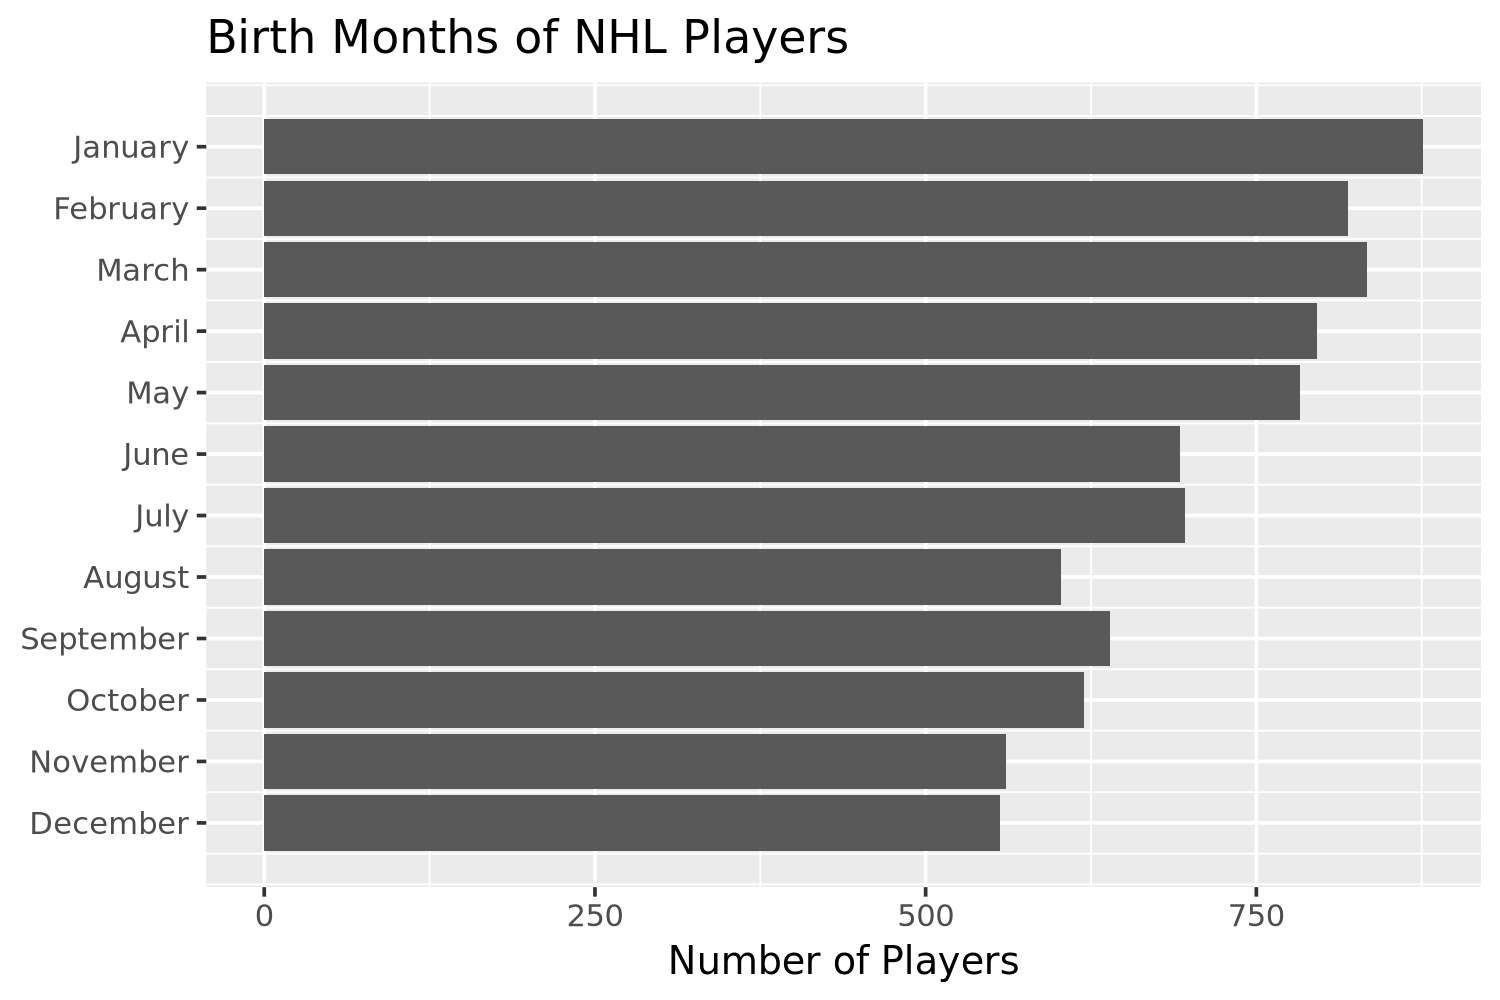

In [161]:
options(repr.plot.height = 4, repr.plot.width = 6)

ggplot(nhl, aes(y=birth_month)) +
    geom_bar() +
    scale_y_reverse(breaks = seq_along(month.name), labels = month.name) +
    labs(title = 'Birth Months of NHL Players', y=NULL, x='Number of Players')

The birth month discrepancy seemed to be the main pattern in the data, but I also wanted to look at where players are coming from. To make things more manageable, I limited my search to the US and Canada, the countries that produce the most talent. The chart below shows the provinces/states where the most players are born in Canada and the US respectively. Canada has fewer, larger provinces than the US does states, so the data look pretty different. Finally, at the bottom I graphed all cities in the US and Canada which have produced at least 5 players on a regional map. As you can see, the area where the majority of players come from follows the US-Canada border pretty closely i.e. most of these cities are far north in the US or far south in Canada. 

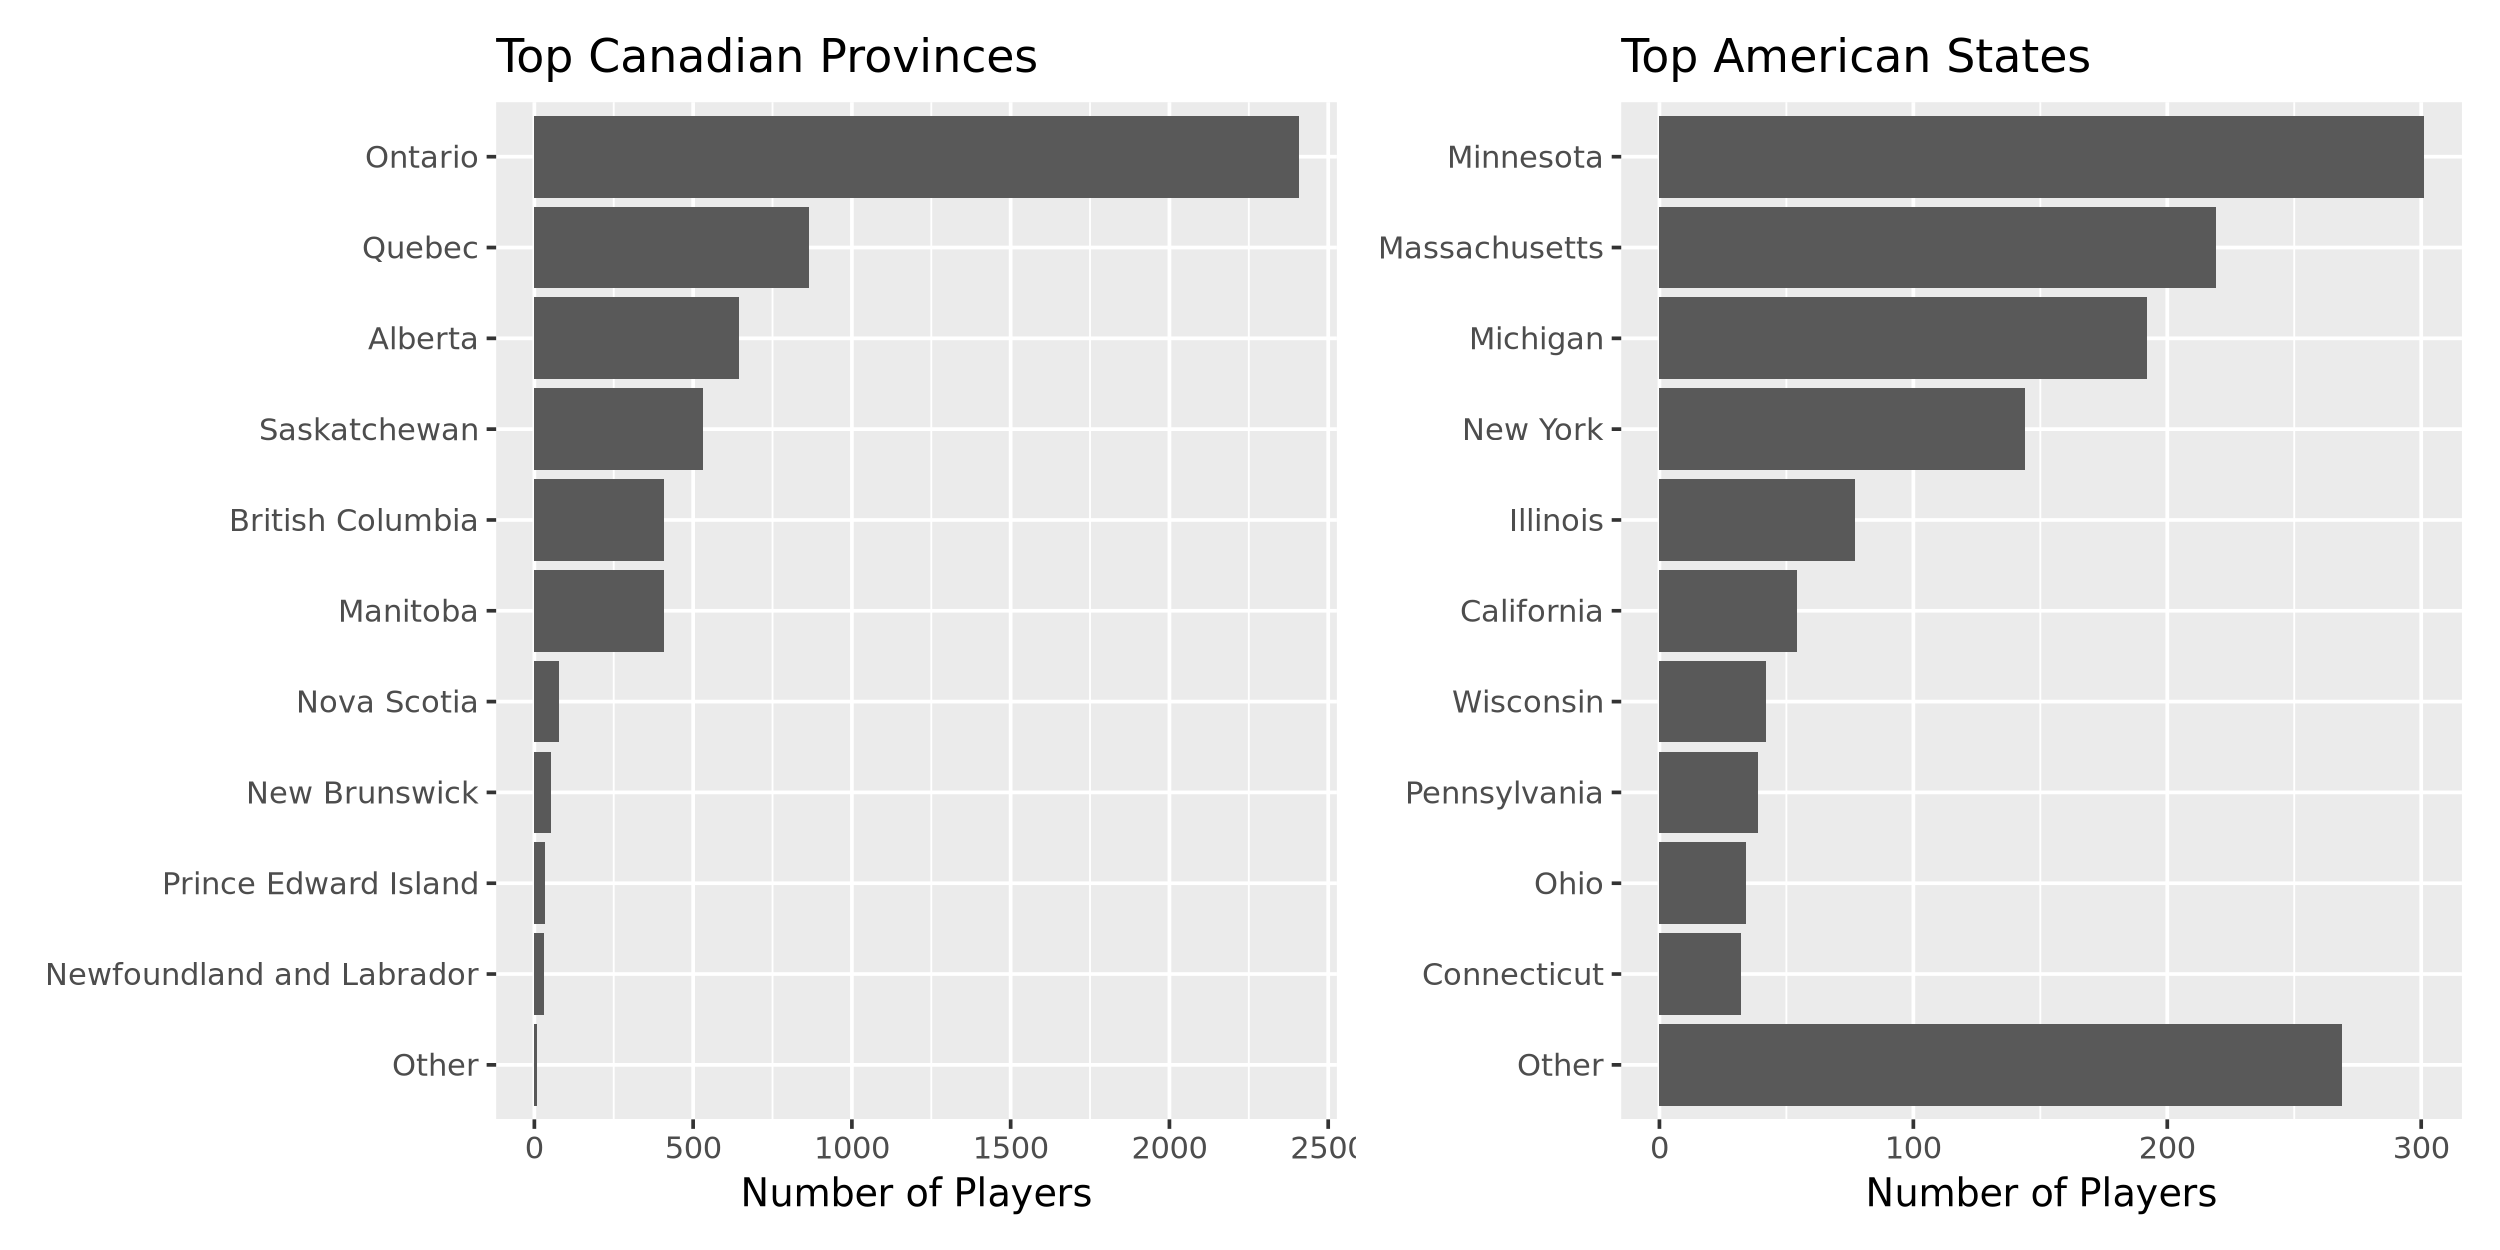

In [167]:
options(repr.plot.height = 5, repr.plot.width = 10)

p = nhl |>
    filter(!is.na(birth_state_province), birth_country=='CAN') |>
    mutate(birth_state_province = fct_lump(birth_state_province, n=10)) |>
    mutate(birth_state_province = fct_infreq(birth_state_province) |> 
           fct_rev() |> 
           fct_relevel('Other')) |>
ggplot(aes(y = birth_state_province)) + 
    geom_bar() +
    labs(title = 'Top Canadian Provinces', y=NULL, x='Number of Players')

p2 = nhl |>
    filter(!is.na(birth_state_province), birth_country=='USA') |>
    mutate(birth_state_province = fct_lump(birth_state_province, n=10)) |>
    mutate(birth_state_province = fct_infreq(birth_state_province) |> 
           fct_rev() |> 
           fct_relevel('Other')) |>
ggplot(aes(y = birth_state_province)) + 
    geom_bar() +
    labs(title = 'Top American States', y=NULL, x='Number of Players')

p + p2

In [96]:
nhl_cities = nhl |> 
    filter(birth_country== c('CAN', 'USA')) |>
    count(birth_city, birth_state_province) |> 
    arrange(-n()) |>
    filter(n >= 5) |>
    geocode(city = birth_city, state = birth_state_province)

# summarize(n_city = n_distinct(birth_city))
# ggplot(aes(x = n)) + geom_histogram(binwidth = 1)

Passing 121 addresses to the Nominatim single address geocoder

Query completed in: 122.3 seconds



Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


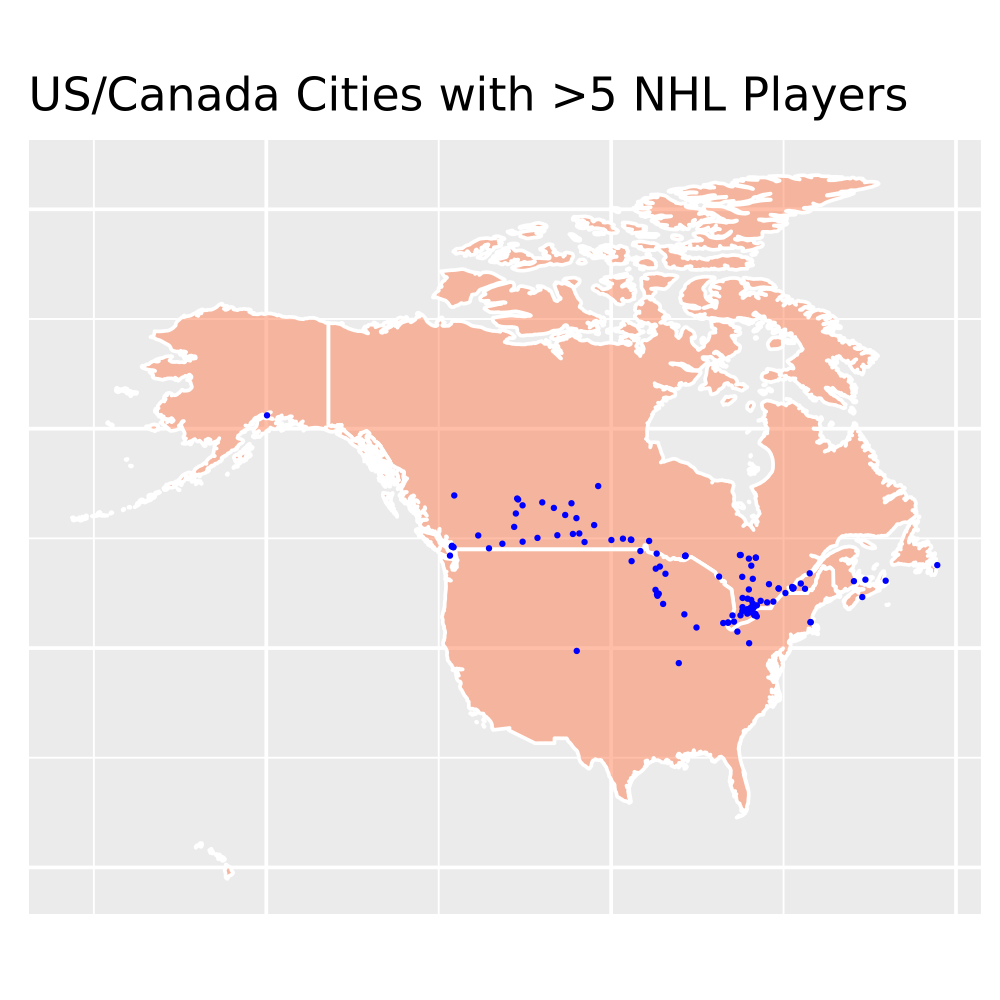

In [125]:
map_data('world', region = c('Canada', 'USA')) |> 
filter(long<0) |>
ggplot() + 
    geom_polygon(aes(x = long, y = lat, group = group), fill = 'coral', color = "white", alpha = 0.5) + 
    coord_quickmap() +
    geom_point(data = nhl_cities, aes(x=long, y=lat), size=.2, color='blue') +
    theme(axis.title=element_blank(),
        axis.text=element_blank(),
        axis.ticks=element_blank()) +
labs(title='US/Canada Cities with >5 NHL Players')